## LIBRERÍAS

In [2]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier

from bayes_opt import BayesianOptimization

## VISUALIZACIÓN

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## EXTRACT

In [3]:
table = pq.read_table(r"D:\MAESTRIA CIENCIA DE DATOS\Fundamentos2\KAGGLE\df_train.parquet")
df_train = table.to_pandas()

table = pq.read_table(r"D:\MAESTRIA CIENCIA DE DATOS\Fundamentos2\KAGGLE\df_test.parquet")
df_test = table.to_pandas()

In [4]:
df_train = df_train.reset_index(drop=True)
df_train

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,cantidad_serv_flia,Pendiente_flia,Intercepto_flia,Promedio_costo_flia,ESTADO_CIVI,PROGRAMA,estrato,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,parentesco,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,HIPERTENSION,HIPERTENSION_FAMILIAR,DIABETES,DIABETES_FAMILIAR,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
0,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,34.0,15998.485714,-23363.200000,48947.25,UL,POS,1,Sobrepeso,Normal,Normal,None,55.0,NaN,14.0,NaN,1.0,5.0,310.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
1,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,25.0,655.200000,-1019.200000,7644.00,SO,POS,1,Sobrepeso,Normal,Normal,None,55.0,NaN,9.0,NaN,1.0,3.0,21.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
2,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,36.0,342236.971429,-521835.400000,1013991.00,CA,POS,1,Sobrepeso,Normal,Normal,None,59.0,NaN,17.0,NaN,1.0,5.0,280.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
3,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,24.0,-4468.285714,30687.333333,22572.50,UL,POS,1,Sobrepeso,Normal,Normal,None,55.0,NaN,4.0,NaN,1.0,3.0,65.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
4,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,7.0,0.000000,0.000000,0.00,SO,POS,1,Obesidad,Normal,Normal,None,53.0,1.0,6.0,NaN,1.0,3.0,28.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,0.0,0.0,1.0,3,0.0,NaN,0.0,NaN,NaN,0.0,22.0,18670.800000,-32290.133333,99173.00,UL,POS,1,Bajo peso,Normal,Normal,None,55.0,NaN,2.0,NaN,1.0,1.0,62.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6628.571429,-15466.666667,4.640000e+04
23490,6.0,0.0,3.0,1,1.0,NaN,0.0,NaN,NaN,1.0,11.0,462.857143,-1080.000000,3240.00,SO,POS,1,Sobrepeso,Normal,Normal,None,49.0,1.0,7.0,-6.25,1.0,3.0,21.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,36161.142857,-66307.333333,9.038500e+04
23491,8.0,2.0,2.0,1,0.0,NaN,0.0,NaN,NaN,0.0,15.0,5247.171429,-5493.266667,38615.50,SO,POS,1,Sobrepeso,Normal,Hipotenso,None,53.0,NaN,11.0,1.35,1.0,5.0,31.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,15912.885714,16190.066667,1.078278e+05
23492,3.0,0.0,1.0,1,0.0,NaN,0.0,NaN,NaN,0.0,4.0,40.000000,-93.333333,280.00,SE,POS,1,Sobrepeso,Normal,Normal,None,56.0,NaN,2.0,NaN,1.0,2.0,299.0,None,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2685.571429,-6266.333333,1.879900e+04


# PIPELINE

In [13]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # 1. Imputar 'estado civil' con 'Sin Descripcion'
        X['ESTADO_CIVI'] = X['ESTADO_CIVI'].fillna('Sin Descripcion')
        
        # 2. Imputar 'CANCER_MAMA_FAMILIAR' con 2 si es nulo
        X['CANCER_MAMA_FAMILIAR'] = X['CANCER_MAMA_FAMILIAR'].fillna('2')
        
        # 3. Reemplazar outliers en medicamentos que superen el percentil 25% con la mediana        
        upper_limit = X['MEDICAMENTOS'].quantile(0.75)
        X['MEDICAMENTOS'] = np.where(X['MEDICAMENTOS'] > upper_limit, X['MEDICAMENTOS'].median(), X['MEDICAMENTOS'])
        
        # 4. Manejo Outliers 'CANTIDAD_SERVICIOS' con el cálculo que establecimos
        X['suma_servicios_medicina'] = X['MEDICINA GENERAL'] + X['MEDICINA ESPECIALIZADA']
        X['dif_cant_serv'] = X['CANTIDAD_SERVICIOS'] - X['suma_servicios_medicina']
        upper_limit = X['CANTIDAD_SERVICIOS'].quantile(0.97)
        X['CANTIDAD_SERVICIOS'] = np.where(
            ((X['dif_cant_serv'] > X['dif_cant_serv'].quantile(0.95)) & (X['CANTIDAD_SERVICIOS'] > upper_limit)),
            upper_limit, X['CANTIDAD_SERVICIOS']
        )
        
        # 5. Imputar la columna 'RIESGOS'
        risk_cols = [
            'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 
            'HIPERTENSION', 'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR',
            'CORONARIOS', 'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
            'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR', 'OTROS_ANTECEDENTES_VASCULARES'
        ]
        X['RIESGOS'] = (X[risk_cols] == '1').sum(axis=1).fillna(X['RIESGOS'])
        
        return X

In [8]:
def plot_predictions_and_scores(scores):

    test_scores = scores['test_score'] 
    train_scores = scores['train_score']
    n_splits = len(test_scores)
    
    plt.figure(figsize=(10, 5))

    plt.plot(range(1, n_splits + 1), test_scores, marker='o', color='green', label='TEST SCORE')
    plt.plot(range(1, n_splits + 1), train_scores, marker='o', color='blue', label='TRAIN SCORE')
    plt.title('Scores por Fold')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(range(1, n_splits + 1))
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(f"Test Score promedio: {np.mean(test_scores):.4f}")
    print(f"Ttrain Score promedio: {np.mean(train_scores):.4f}")

In [9]:
def plot_test(y_test, y_pred,score):
    plt.figure(figsize=(10, 5))

    # Gráfico 1: Valores reales vs predicciones
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(y_test)), y_test, label='Valores Reales', color='blue', alpha=0.5)
    plt.scatter(range(len(y_pred)), y_pred, label='Predicciones', color='red', alpha=0.5)
    plt.title('Valores Reales vs Predicciones (Test Set)')
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.legend()

    # Gráfico 2: Puntaje del conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.bar(['Test Score'], [score], color='green')
    plt.title('Score en el Conjunto de Prueba')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

In [32]:
def train_evaluate_svm(knn_imputer_k,pca_components,SVC_C,SVC_gamma,kfold,imputer_strategy,pca_strategy):
    X = df_train.drop('Target', axis=1) 
    y = df_train['Target'] 
    
    # Eliminar las columnas referente a costos
    """X = X.drop(['Pendiente_flia', 'Pendiente', 'Intercepto_flia', 'Intercepto',
                'Promedio_costo', 'Promedio_costo_flia','psa_max_gr_flia',
                'psa_min_gr_flia','min_Tiempo_CP_Fliar'], 
               axis=1)"""
               
    X = X.drop(['psa_max_gr_flia',
            'psa_min_gr_flia','min_Tiempo_CP_Fliar'], 
            axis=1)
    
    
    X = X.replace({'None': np.nan})
    
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    

    pca_components = int(round(pca_components))  # Usar round para asegurar enteros
    kfold = int(round(kfold))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    num_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('knn_imputer', KNNImputer(n_neighbors=int(knn_imputer_k))),
        ('pca', PCA(n_components=int(pca_components)))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])


    # rf_cat_transformers = [(f'rf_imputer_{col}', 
    #                         Pipeline(steps=[
    #                             #('ordinal', OrdinalEncoder()),
    #                             ('rf_imputer', RandomForestImputer(target_column=col)),
    #                             ('onehot', OneHotEncoder(handle_unknown='ignore'))
    #                         ]), 
    #                         list(categorical_cols) + list(numerical_cols)) for col in categorical_cols if X[col].isnull().sum() > 0]

    # Preprocesamiento con ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        #*rf_cat_transformers,
    ])

    # Definir pipeline completo
    pipeline = Pipeline(steps=[
        ('custom', CustomTransformer()),
        ('preprocessor', preprocessor),          
        ('svm', SVC(C=SVC_C, gamma=SVC_gamma, kernel='linear', probability=True))
    ])


    kf = KFold(n_splits=int(kfold),shuffle=True, random_state=42)
    
    try:
        scores = cross_validate(pipeline, X_train, y_train, cv=kf, return_train_score=True)
        print("Validación cruzada exitosa.")
        print("Scores:", scores)   
    except Exception as e:
        print(f"Error en cross_validate: {e}")
   
    test_scores = scores['test_score'] 
    train_scores = scores['train_score']
    adj_val_f1 = ( test_scores.mean() -  test_scores.std())
    adj_train_f1 = ( train_scores.mean() -  train_scores.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)

    plot_predictions_and_scores(scores)
    
    return objective    

In [5]:
X = df_train.drop('Target', axis=1) 
y = df_train['Target'] 

# Eliminar las columnas referente a costos
"""X = X.drop(['Pendiente_flia', 'Pendiente', 'Intercepto_flia', 'Intercepto',
            'Promedio_costo', 'Promedio_costo_flia','psa_max_gr_flia',
            'psa_min_gr_flia','min_Tiempo_CP_Fliar'], 
            axis=1)"""
            
X = X.drop(['psa_max_gr_flia',
        'psa_min_gr_flia','min_Tiempo_CP_Fliar'], 
        axis=1)


X = X.replace({'None': np.nan})

X['ESTADO_CIVI'] = X['ESTADO_CIVI'].fillna('Sin Descripcion')
        
# 2. Imputar 'CANCER_MAMA_FAMILIAR' con 2 si es nulo
X['CANCER_MAMA_FAMILIAR'] = X['CANCER_MAMA_FAMILIAR'].fillna('2')

# 3. Reemplazar outliers en medicamentos que superen el percentil 25% con la mediana        
upper_limit = X['MEDICAMENTOS'].quantile(0.75)
X['MEDICAMENTOS'] = np.where(X['MEDICAMENTOS'] > upper_limit, X['MEDICAMENTOS'].median(), X['MEDICAMENTOS'])

# 4. Manejo Outliers 'CANTIDAD_SERVICIOS' con el cálculo que establecimos
X['suma_servicios_medicina'] = X['MEDICINA GENERAL'] + X['MEDICINA ESPECIALIZADA']
X['dif_cant_serv'] = X['CANTIDAD_SERVICIOS'] - X['suma_servicios_medicina']
upper_limit = X['CANTIDAD_SERVICIOS'].quantile(0.97)
X['CANTIDAD_SERVICIOS'] = np.where(
        ((X['dif_cant_serv'] > X['dif_cant_serv'].quantile(0.95)) & (X['CANTIDAD_SERVICIOS'] > upper_limit)),
        upper_limit, X['CANTIDAD_SERVICIOS']
)

# 5. Imputar la columna 'RIESGOS'
risk_cols = [
        'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 
        'HIPERTENSION', 'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR',
        'CORONARIOS', 'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
        'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR', 'OTROS_ANTECEDENTES_VASCULARES'
]
X['RIESGOS'] = (X[risk_cols] == '1').sum(axis=1).fillna(X['RIESGOS'])

In [6]:
def get_nulos(df):
    nulos_mayores_que_cero = df.isnull().sum()
    nulos_mayores_que_cero = nulos_mayores_que_cero[nulos_mayores_que_cero > 0]
    print(nulos_mayores_que_cero)

In [7]:
get_nulos(X)

estrato                      2
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
parentesco               17125
PERDIDA_DE_PESO          17723
dtype: int64


In [8]:
def train_evaluate_svm2(knn_imputer_k,pca_components,SVC_C,SVC_gamma,kfold,imputer_strategy,pca_strategy):
    
    global X,y
    
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    

    pca_components = int(round(pca_components))  # Usar round para asegurar enteros
    kfold = int(round(kfold))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    num_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('knn_imputer', KNNImputer(n_neighbors=int(knn_imputer_k))),
        ('pca', PCA(n_components=int(pca_components)))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    # Definir pipeline completo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),          
        ('svm', SVC(C=SVC_C, gamma=SVC_gamma, kernel='linear', probability=True))
    ])


    kf = KFold(n_splits=int(kfold),shuffle=True, random_state=42)
    
    try:
        scores = cross_validate(pipeline, X_train, y_train, cv=kf, return_train_score=True)
        print("Validación cruzada exitosa.")
        print("Scores:", scores)   
    except Exception as e:
        print(f"Error en cross_validate: {e}")
   
    test_scores = scores['test_score'] 
    train_scores = scores['train_score']
    adj_val_f1 = ( test_scores.mean() -  test_scores.std())
    adj_train_f1 = ( train_scores.mean() -  train_scores.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)

    plot_predictions_and_scores(scores)
    
    return objective    

In [26]:
def train_evaluate_mlp(knn_imputer_k,pca_components,kfold,model_hidden_layer_size_exp,
                       model_lr_init,model_alpha,model_batch_size,model_max_iter):
    X = df_train.drop('Target', axis=1) 
    y = df_train['Target'] 
    
    # Eliminar las columnas referente a costos
    """X = X.drop(['Pendiente_flia', 'Pendiente', 'Intercepto_flia', 'Intercepto',
                'Promedio_costo', 'Promedio_costo_flia','psa_max_gr_flia',
                'psa_min_gr_flia','min_Tiempo_CP_Fliar'], 
               axis=1)"""
               
    X = X.drop(['psa_max_gr_flia',
                'psa_min_gr_flia','min_Tiempo_CP_Fliar'], 
               axis=1)
    
    
    X = X.replace({'None': np.nan})
    
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    

    pca_components = int(round(pca_components))  # Usar round para asegurar enteros
    kfold = int(round(kfold))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    num_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('knn_imputer', KNNImputer(n_neighbors=int(knn_imputer_k))),
        ('pca', PCA(n_components=int(pca_components)))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    max_exponent = int(model_hidden_layer_size_exp)
    if max_exponent<2:
        max_exponent=2
        
    model_kwargs = dict(
        hidden_layer_sizes = [2**(n) for n in reversed(range(2, max_exponent+1))], 
        batch_size=2**int(model_batch_size), 
        learning_rate_init=model_lr_init,
        alpha=model_alpha,
        max_iter=int(model_max_iter),
        early_stopping=True,
        random_state=42,
    )


    # Preprocesamiento con ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    

    # Definir pipeline completo
    pipeline = Pipeline(steps=[
        ('custom', CustomTransformer()),
        ('preprocessor', preprocessor),  
        ('mlp', MLPClassifier(**model_kwargs))
    ])


    kf = KFold(n_splits=int(kfold),shuffle=True, random_state=42)
    
    try:
        scores = cross_validate(pipeline, X_train, y_train, cv=kf, return_train_score=True, n_jobs=-1)
        print("Validación cruzada exitosa.")
        print("Scores:", scores)   
    except Exception as e:
        print(f"Error en cross_validate: {e}")
 
   
    test_scores = scores['test_score'] 
    train_scores = scores['train_score']
    adj_val_f1 = ( test_scores.mean() -  test_scores.std())
    adj_train_f1 = ( train_scores.mean() -  train_scores.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)

    plot_predictions_and_scores(scores)
 
    """pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)

  
    classes = pipeline.classes_
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_pred = classes[y_pred_classes]

    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy: {accuracy}")"""
    
    return objective    

## OPTIMIZACIÓN BAYESIANA

In [18]:
pbounds_SVM = dict(
    pca_components=(2, 4),
    knn_imputer_k=(3, 10),
    SVC_C=(0.001, 0.1),
    SVC_gamma=(0,2),
    kfold=(5,10),
    imputer_strategy=(0, 1)  
    pca_strategy=(0, 1) 
)

optimizer_SVM = BayesianOptimization(
    f=train_evaluate_svm,
    pbounds=pbounds_SVM,
    random_state=963,
    verbose=2,
)

|   iter    |  target   |   SVC_C   | SVC_gamma |   kfold   | knn_im... | pca_co... |
-------------------------------------------------------------------------------------
Validación cruzada exitosa.
Scores: {'fit_time': array([67.66412306, 72.14976645, 68.19728327, 61.5386529 , 65.58716583,
       64.36689115, 68.61545277, 71.11254621]), 'score_time': array([3.90049648, 4.80243611, 4.86191821, 2.79253316, 3.57915568,
       3.26464057, 3.78325534, 4.96033049]), 'test_score': array([0.72425532, 0.72851064, 0.71021277, 0.71434653, 0.73094934,
       0.71264368, 0.71051511, 0.69816943]), 'train_score': array([0.71505017, 0.71444208, 0.71705686, 0.71646601, 0.71409461,
       0.71670923, 0.71701326, 0.7187766 ])}


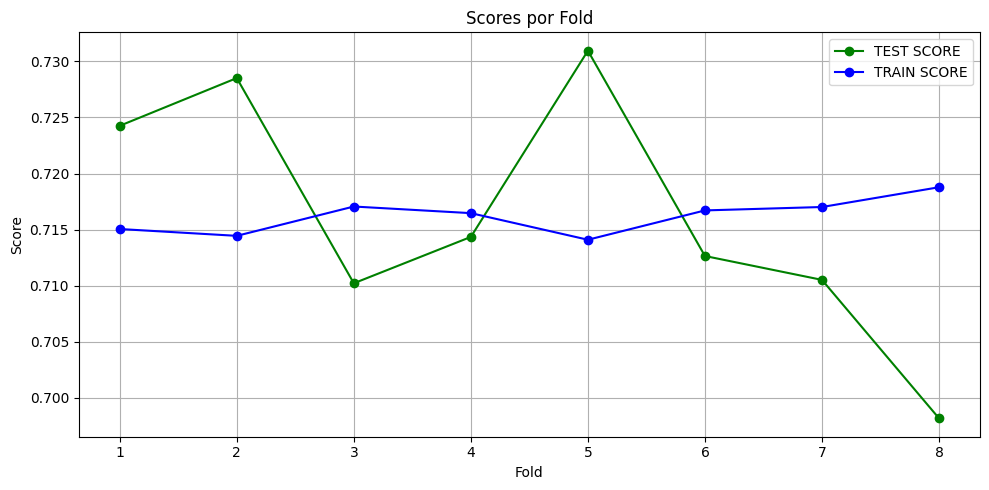

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
f predict: [[0.71618455 0.28381545]
 [0.71617742 0.28382258]
 [0.71622172 0.28377828]
 ...
 [0.71617462 0.28382538]
 [0.71620567 0.28379433]
 [0.71618097 0.28381903]]
accuracy: 0.7120663971057671


TypeError: plot_test() missing 2 required positional arguments: 'y_pred' and 'score'

In [19]:
optimizer_SVM.maximize(
    init_points=2,
    n_iter=5,
)

In [251]:
optimizer_SVM.max

{'target': 0.7008626821695733,
 'params': {'SVC_C': 0.1,
  'SVC_gamma': 2.0,
  'kfold': 8.98961479723088,
  'knn_imputer_k': 3.0,
  'pca_components': 4.0}}

In [27]:
pbounds_MLP = dict(
    pca_components=(2, 4),
    knn_imputer_k=(3, 10),
    kfold=(5,10),
    model_hidden_layer_size_exp=(2, 4),
    model_lr_init=(0.005, 0.5),
    model_alpha=(0.001, 1),
    model_batch_size=(3, 7), 
    model_max_iter=(50, 50)  
)

optimizer_MLP = BayesianOptimization(
    f=train_evaluate_mlp,
    pbounds=pbounds_MLP,
    random_state=963,
    verbose=2,
)

|   iter    |  target   |   kfold   | knn_im... | model_... | model_... | model_... | model_... | model_... | pca_co... |
-------------------------------------------------------------------------------------------------------------------------
Validación cruzada exitosa.
Scores: {'fit_time': array([25.83496189, 26.93414211, 26.33798838, 26.27785087, 25.80303049,
       27.45564747]), 'score_time': array([5.22649336, 4.0042069 , 4.59954286, 4.09648228, 5.67158532,
       4.74406743]), 'test_score': array([0.72454516, 0.72231088, 0.71113948, 0.72190294, 0.71583653,
       0.70146871]), 'train_score': array([0.71453199, 0.71497893, 0.71721364, 0.71506097, 0.71627402,
       0.71914703])}


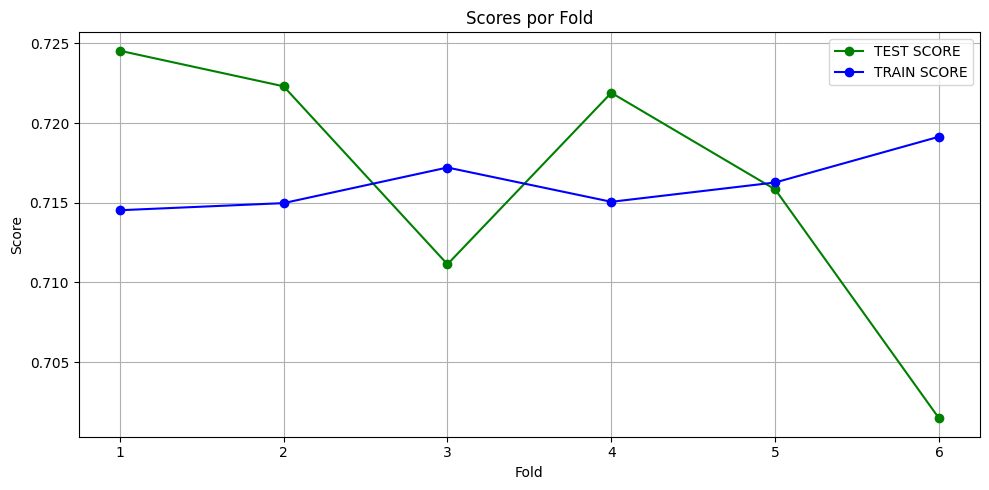

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
| 1         | 0.7018    | 5.573     | 3.694     | 0.6679    | 6.236     | 2.127     | 0.08031   | 50.0      | 3.238     |
Validación cruzada exitosa.
Scores: {'fit_time': array([34.11004686, 30.18140197, 32.02785826, 32.1028142 , 29.97409153,
       34.1434269 , 34.40825057, 30.29839683, 31.27457881, 32.49873447]), 'score_time': array([2.52167273, 3.08183122, 2.51688957, 2.52893257, 2.72043228,
       2.99132562, 3.23603749, 2.56992722, 3.10321546, 2.21011519]), 'test_score': array([0.71755319, 0.73351064, 0.72765957, 0.70425532, 0.71382979,
       0.72698244, 0.72325705, 0.71633848, 0.70303353, 0.69558276]), 'train_score': array([0.71605084, 0.71427727, 0.71492758, 0.71752882, 0.71646468,
       0.71500355, 0.71541736, 0.71618586, 0.71766375, 0.71849137])}


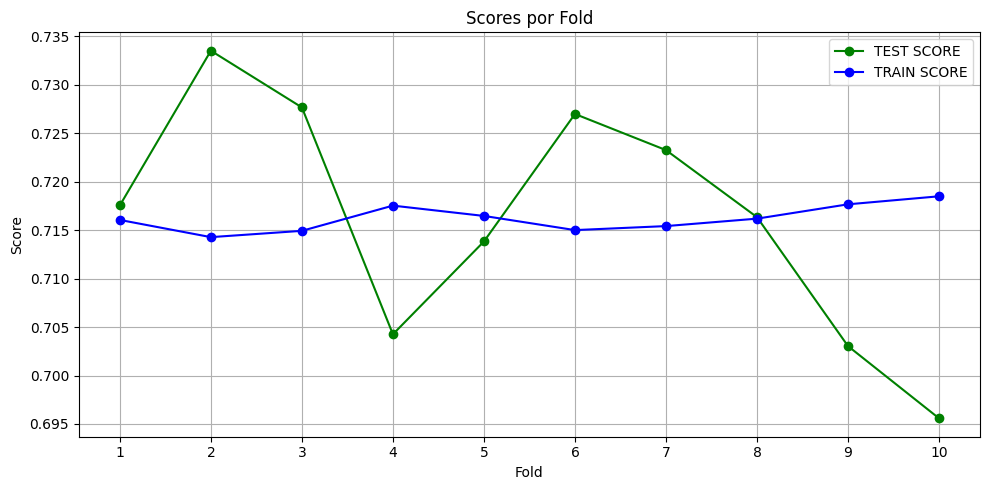

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
| 2         | 0.6943    | 9.644     | 6.916     | 0.6132    | 5.861     | 2.211     | 0.1468    | 50.0      | 2.015     |
Validación cruzada exitosa.
Scores: {'fit_time': array([44.01002359, 49.7414577 , 48.30767012, 48.68230081, 39.90556908,
       47.68373871, 38.331599  , 47.56337905, 44.31303692]), 'score_time': array([3.51025963, 2.82805848, 2.91519499, 3.32566929, 3.43629336,
       2.88973331, 3.06834841, 3.14195204, 3.18447137]), 'test_score': array([0.72379129, 0.72522738, 0.7213978 , 0.71216475, 0.72126437,
       0.71599617, 0.72030651, 0.7059387 , 0.69971264]), 'train_score': array([0.71525201, 0.71507243, 0.7155513 , 0.71670557, 0.71556832,
       0.71622673, 0.71568803, 0.71748369, 0.71826181])}


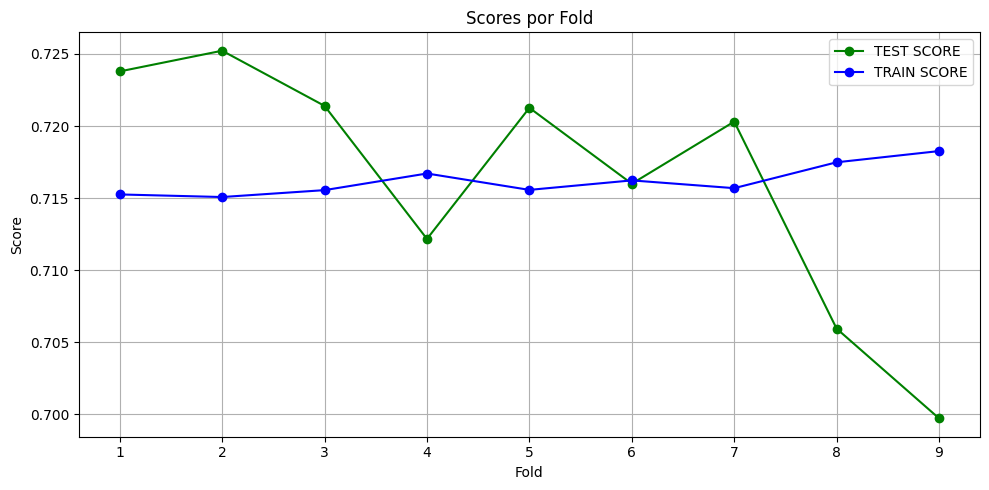

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
| 3         | 0.7009    | 9.022     | 4.83      | 0.8444    | 3.108     | 2.067     | 0.01927   | 50.0      | 2.503     |
Validación cruzada exitosa.
Scores: {'fit_time': array([25.97835779, 28.2909534 , 22.68808198, 23.34830618, 25.94664121,
       25.86034989]), 'score_time': array([4.17411423, 4.07066917, 4.54427195, 4.29687285, 5.41162634,
       5.05055523]), 'test_score': array([0.72454516, 0.72231088, 0.71113948, 0.72190294, 0.71583653,
       0.70146871]), 'train_score': array([0.71453199, 0.71497893, 0.71721364, 0.71506097, 0.71627402,
       0.71914703])}


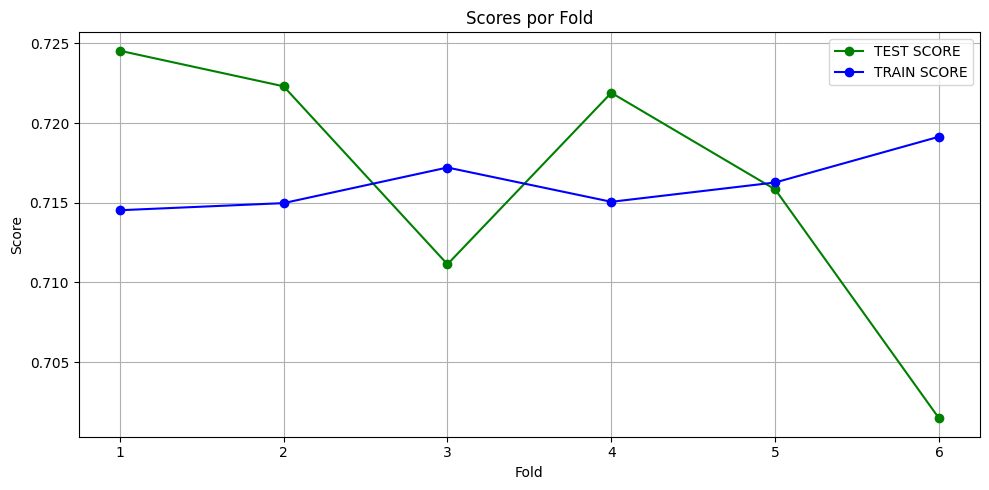

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
| 4         | 0.7018    | 6.404     | 3.679     | 0.2374    | 6.259     | 2.611     | 0.03854   | 50.0      | 3.052     |
Validación cruzada exitosa.
Scores: {'fit_time': array([42.2735455 , 15.44505644, 15.43356752, 16.1879971 , 44.76621008,
       39.77578759]), 'score_time': array([2.19768023, 2.01634789, 2.22915864, 3.72857141, 4.72808719,
       4.62207937]), 'test_score': array([0.72454516, 0.72231088, 0.71113948, 0.72190294, 0.71583653,
       0.70146871]), 'train_score': array([0.71453199, 0.71497893, 0.71721364, 0.71506097, 0.71627402,
       0.71914703])}


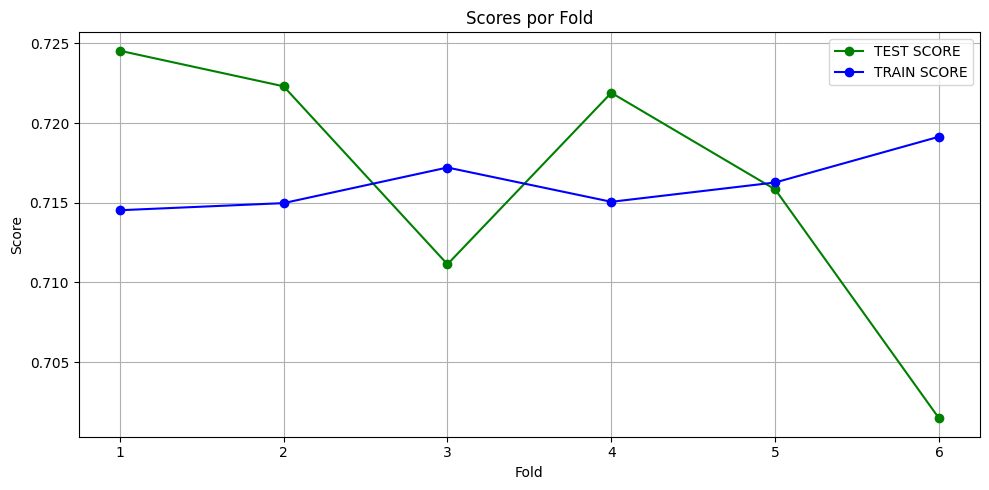

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
| 5         | 0.7018    | 6.138     | 3.0       | 0.4966    | 3.0       | 2.641     | 0.005     | 50.0      | 3.527     |
Validación cruzada exitosa.
Scores: {'fit_time': array([50.34611106, 50.11849809, 46.38285589, 46.76183438, 44.15144324]), 'score_time': array([4.84929514, 4.82440138, 5.22586966, 5.61655331, 5.80628324]), 'test_score': array([0.7254589 , 0.71588188, 0.72067039, 0.71960628, 0.69938814]), 'train_score': array([0.71388667, 0.71628093, 0.7150838 , 0.71534983, 0.72040436])}


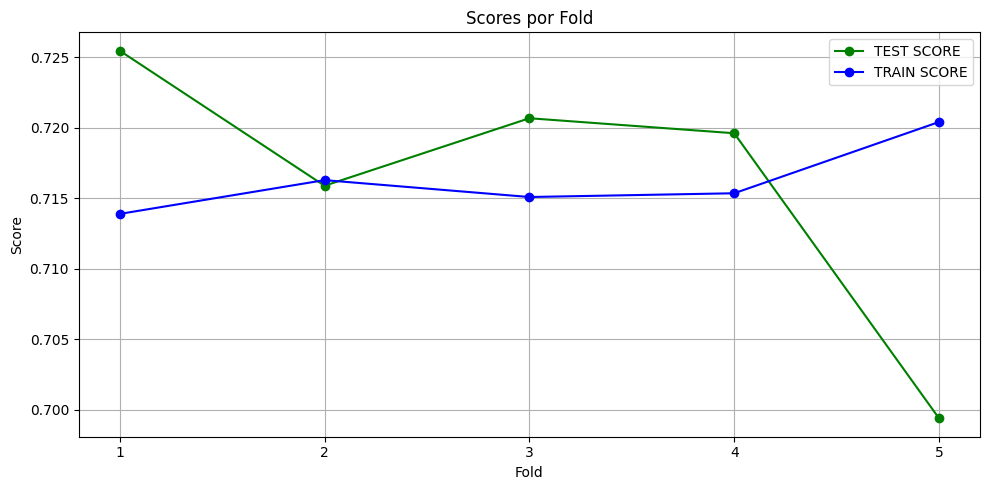

Test Score promedio: 0.7162
Ttrain Score promedio: 0.7162
| 6         | 0.7005    | 5.0       | 6.222     | 0.001     | 3.0       | 4.0       | 0.5       | 50.0      | 4.0       |


KeyboardInterrupt: 

In [28]:
optimizer_MLP.maximize(
    init_points=2,
    n_iter=5,
)

In [ ]:
optimizer_MLP.max

In [9]:
train_evaluate_svm2(
    pca_components=3,
    knn_imputer_k=3,
    SVC_C=0.001,
    SVC_gamma=0.1,
    kfold=5,
    imputer_strategy=1,
    pca_strategy=1)

NameError: name 'train_evaluate_svm' is not defined

In [ ]:
# Updated preprocessing pipeline
# Make sure you have the correct categorization of columns: numeric, ordinal, and nominal

from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.05)),
    ('scaler', StandardScaler()),
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Added dense output for compatibility
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, updated_numeric_columns),  # Process numeric columns
        ('ord', ordinal_transformer, updated_ordinal_columns),  # Process ordinal columns
        ('nom', nominal_transformer, updated_nominal_columns)   # Process nominal columns
    ]
)

# Ensure that the preprocessing pipeline is used before PCA in your pipeline
# Number of components for PCA (adjust as needed)
n_components_pca = 5  # Adjust based on your dataset

# Define the SVM evaluation function with the updated pipeline
def svm_evaluate(C, gamma, kernel_choice):
    kernel = 'linear' if kernel_choice < 0.5 else 'rbf'
    # kernel = 'linear'
    
    # Create a complete pipeline: PCA + preprocessing + SVM
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Include the preprocessing pipeline
        ('pca', PCA(n_components=n_components_pca, random_state=42)),  # Add PCA after preprocessing
        ('svm', SVC(C=C, gamma=gamma, kernel=kernel, probability=True))  # SVM with hyperparameters
    ])
    
    # Perform K-fold cross-validation and return mean ROC AUC score
    roc_auc_scores = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='roc_auc', verbose=0)
    
    return roc_auc_scores.mean()

# Define the parameter bounds for Bayesian Optimization
pbounds = {
    'C': (1, 5),       # Regularization parameter
    'gamma': (0.5, 1),  # Kernel coefficient for 'rbf'
    'kernel_choice': (0, 1)  # 0 for 'linear', 1 for 'rbf'
}

# Set up the Bayesian optimizer
optimizer = BayesianOptimization(
    f=svm_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run the optimization without the progress bar
optimizer.maximize(init_points=2, n_iter=3)

# Output the best parameters
best_params = optimizer.max
print("Best parameters found:", best_params)

# Train the final SVM model with the best parameters
C_opt = best_params['params']['C']
gamma_opt = best_params['params']['gamma']
kernel_opt = 'linear' if best_params['params']['kernel_choice'] < 0.5 else 'rbf'

# Final pipeline with best hyperparameters
best_svm_model = Pipeline([
    ('preprocessor', preprocessor),  # Include the preprocessing pipeline
    ('pca', PCA(n_components=n_components_pca, random_state=42)),  # Add PCA
    ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, probability=True))  # Best SVM model
])


In [ ]:
# Submission
test_df = pd.read_parquet(osp.join(DATA_DIR, "df_test.parquet"))
submission_pred = best_model.predict_proba(test_df)[:, 1]
#submission_pred_bool = submission_pred>best_th
#submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))
submission.to_csv("submission_NN.csv", index=False)

In [ ]:
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict_proba(X_test)

    classes = pipeline.named_steps['svm'].classes_
    y_pred_classes = np.argmax(y_pred_test, axis=1)

    # Mapear los índices de las clases a las etiquetas reales usando 'classes_'
    y_pred = classes[y_pred_classes]

    # Calcular el accuracy entre las etiquetas predichas y las reales
    accuracy = accuracy_score(y_test, y_pred)
    
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Clase positiva

    # Calcular el ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"accuracy: {accuracy}")